# Imports

In [358]:
!pip install catboost

In [359]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost

from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Settings

In [360]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


# Read data

In [361]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [362]:
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combine data

In [363]:
def reduce_df(df, group_by='building_id', date_col='date_forecast'):
    #minute = df['date_forecast'].dt.minute
    hourDayMonthYear = df[date_col].dt.floor('H')
    

    df_new = df.groupby([group_by, date_col]).any().reset_index() #just use any aggregations function --> will be overwrittern anyway

    for row_idx in df_new.index:
        if row_idx % 10 == 0:
            print(row_idx)
        building_id = df_new.loc[row_idx, 'building_id']
        hourDayMonthYear = df_new.loc[row_idx, date_col].floor('H')

        row_0  = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 0]
        row_15 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 15]
        row_30 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 30]
        row_45 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 45]
        row_60 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == (hourDayMonthYear + + pd.Timedelta(hours=1))) & df[date_col].dt.minute == 0]

        

        rows = pd.concat(
            [
                row_0, 
                row_15, 
                row_15, 
                row_30, 
                row_30, 
                row_45, 
                row_45, 
                row_60
            ],
            axis=0)
        
        rows_mean = (rows.groupby(group_by).mean().reset_index()).loc[0,:]

        df_new.loc[row_idx,:] = rows_mean
        
    return df_new


In [364]:
#reduce_df(X_train_observed_a)


In [365]:
# Combine Data
X_o = pd.concat([X_train_observed_a, X_train_observed_b, X_train_observed_c])
X_e = pd.concat([X_train_estimated_a, X_train_estimated_b, X_train_estimated_c])
X_submission = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
y = pd.concat([train_a, train_b, train_c])

# Add isEstimated column
X_o['isEstimated'] = 0
X_e['isEstimated'] = 1
X_submission['isEstimated'] = 1


# Combine
X = pd.concat([X_o, X_e])

# Add time column that only holds the hour
X['time'] = X['date_forecast'].dt.floor('H')
X_submission['time'] = X_submission['date_forecast'].dt.floor('H')

# combine X and y
Xy = pd.merge(X, y, on=['building_id', 'time'], how='inner')

# Add monthYear column
Xy['monthYear'] = Xy['date_forecast'].dt.to_period('M')
X_submission['monthYear'] = X_submission['date_forecast'].dt.to_period('M')

# Add dayMonthYear column
Xy['dayMonthYear'] = Xy['date_forecast'].dt.to_period('D')
X_submission['dayMonthYear'] = X_submission['date_forecast'].dt.to_period('D')

# Add month column
Xy['month'] = Xy['date_forecast'].dt.month
X_submission['month'] = X_submission['date_forecast'].dt.month

# Add hour column
Xy['hour'] = Xy['date_forecast'].dt.hour
X_submission['hour'] = X_submission['date_forecast'].dt.hour

# Prepare for joining ->The data is grouped per building and hour
Xy = Xy.groupby(['building_id', 'time']).mean().reset_index()
X_submission = X_submission.groupby(['building_id', 'time']).mean().reset_index()

# Create additional feature for estimated data "delta_forecast"
Xy['delta_forecast'] = (Xy['time']-Xy['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_submission['delta_forecast'] = (X_submission['time']-X_submission['date_calc']).apply(lambda x: x.total_seconds() / 3600)

#TODO: remove, only for testing
# Xy_o = Xy_o[Xy_o['building_id'] == 'a']
# Xy_e = Xy_e[Xy_e['building_id'] == 'a']





<Axes: xlabel='time', ylabel='pv_measurement'>

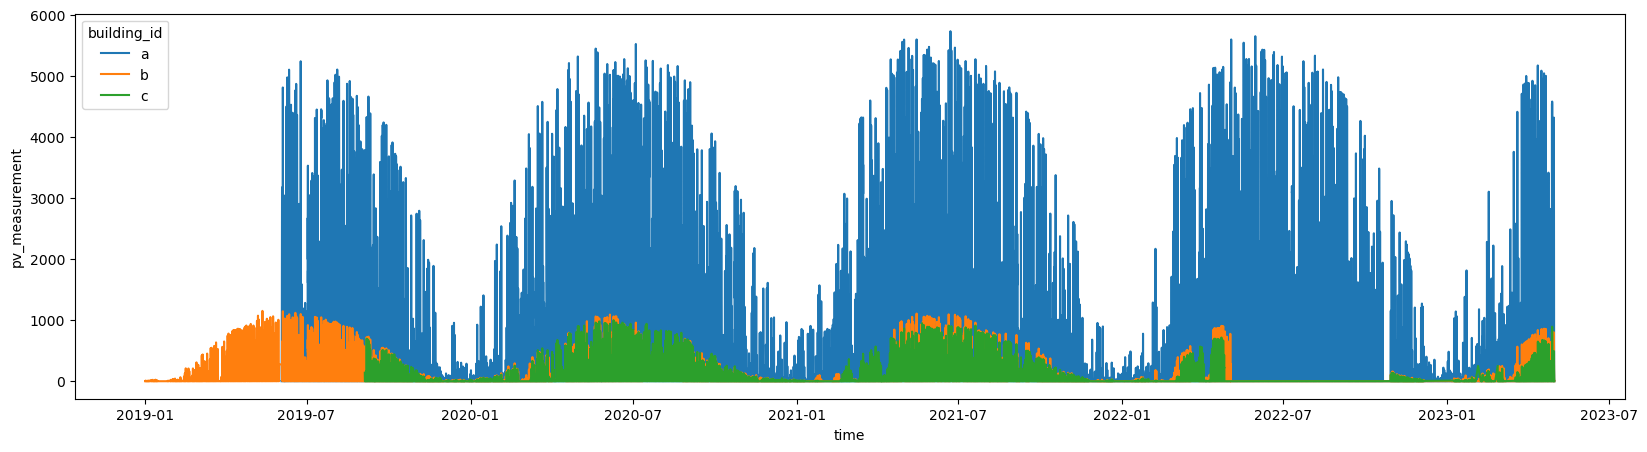

In [366]:
plt.figure(figsize=(20,5))
sns.lineplot(data=Xy, x='time', y='pv_measurement', hue='building_id')

# DATA CLEANING

In [367]:
# TODO: copy to new file

Xy = Xy[~((Xy['building_id'] == 'c') & (Xy['date_forecast'] < '2019-09-06'))] # C is powered on on this day -> weird measurements
Xy = Xy[~((Xy['building_id'] == 'c') & (Xy['date_forecast'].between('2020-05-13','2020-05-14')))] # C is powered on on this day -> weird measurements

eq_prev_row = (
    ((Xy.pv_measurement == Xy.pv_measurement.shift(-2)) & (Xy.pv_measurement == Xy.pv_measurement.shift(-1))) |
    ((Xy.pv_measurement == Xy.pv_measurement.shift(-1)) & (Xy.pv_measurement == Xy.pv_measurement.shift(1))) | 
    (Xy.pv_measurement == Xy.pv_measurement.shift(1)) & (Xy.pv_measurement == Xy.pv_measurement.shift(2))
    ) & (Xy.pv_measurement > 0)
Xy = Xy[~eq_prev_row].reset_index(drop=True) # Mostly Solar Panel B has some constant values for up to 1000 measurements

zeroData_24h = Xy.groupby(['building_id'])['pv_measurement'].transform(lambda x: x.rolling(24, 24).sum()) == 0
for i in range(1,24):
    zeroData_24h = zeroData_24h | zeroData_24h.copy(deep=True).shift(-1)
Xy = Xy[~zeroData_24h].reset_index(drop=True) # Solar Panels B and C have some 0 values for longer than 24h, also in summer


# Feature engineering

In [368]:
max_val = 1

Xy['GHI'] = Xy['diffuse_rad:W'] + Xy['direct_rad:W']
Xy['wind_angle'] = np.arctan2(Xy['wind_speed_u_10m:ms'], Xy['wind_speed_v_10m:ms'])
Xy['norm_radiation'] = (Xy['GHI'] / Xy['clear_sky_rad:W']).fillna(0)
Xy.loc[Xy['norm_radiation'] > max_val, 'norm_radiation'] = max_val

X_submission['GHI'] = X_submission['diffuse_rad:W'] + X_submission['direct_rad:W']
X_submission['wind_angle'] = np.arctan2(X_submission['wind_speed_u_10m:ms'], X_submission['wind_speed_v_10m:ms'])
X_submission['norm_radiation'] = (X_submission['GHI'] / X_submission['clear_sky_rad:W']).fillna(0)
X_submission.loc[X_submission['norm_radiation'] > max_val, 'norm_radiation'] = max_val


In [369]:
# TODO: copy to new file
Xy['wind_angle_sin'] = np.sin(Xy['wind_angle'])
Xy['wind_angle_cos'] = np.cos(Xy['wind_angle'])

Xy['hour_sin'] = np.sin(Xy['hour'] * (2. * np.pi / 24))
Xy['hour_cos'] = np.cos(Xy['hour'] * (2. * np.pi / 24))

X_submission['wind_angle_sin'] = np.sin(X_submission['wind_angle'])
X_submission['wind_angle_cos'] = np.cos(X_submission['wind_angle'])

X_submission['hour_sin'] = np.sin(X_submission['hour'] * (2. * np.pi / 24))
X_submission['hour_cos'] = np.cos(X_submission['hour'] * (2. * np.pi / 24))

# Lagged Features

In [370]:
# lagged feature of GHI
#Xy['GHI_lag-2'] = Xy.groupby('building_id')['GHI'].shift(-2)
Xy['GHI_lag-1'] = Xy.groupby('building_id')['GHI'].shift(-1)
Xy['GHI_lag1'] = Xy.groupby('building_id')['GHI'].shift(1)
#Xy['GHI_lag2'] = Xy.groupby('building_id')['GHI'].shift(2)

#X_submission['GHI_lag-2'] = X_submission.groupby('building_id')['GHI'].shift(-2)
X_submission['GHI_lag-1'] = X_submission.groupby('building_id')['GHI'].shift(-1)
X_submission['GHI_lag1'] = X_submission.groupby('building_id')['GHI'].shift(1)
#X_submission['GHI_lag2'] = X_submission.groupby('building_id')['GHI'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    #'GHI_lag-2', 
    'GHI_lag-1', 
    'GHI_lag1', 
    #'GHI_lag2'
    ])


# Daily Mean

In [371]:
# add daily mean of GHI
Xy['GHI_mean'] = Xy.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')
X_submission['GHI_mean'] = X_submission.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')

Xy['GHI_std'] = Xy.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('std')
X_submission['GHI_std'] = X_submission.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('std')



# Feature differences  

In [372]:
#Xy['GHI_0_minus_-2'] = Xy['GHI'] - Xy['GHI_lag-2']
Xy['GHI_0_minus_-1'] = Xy['GHI'] - Xy['GHI_lag-1']
Xy['GHI_0_minus_1'] = Xy['GHI'] - Xy['GHI_lag1']
#Xy['GHI_0_minus_2'] = Xy['GHI'] - Xy['GHI_lag2']

# X_submission['GHI_0_minus_-2'] = X_submission['GHI'] - X_submission['GHI_lag-2']
X_submission['GHI_0_minus_-1'] = X_submission['GHI'] - X_submission['GHI_lag-1']
X_submission['GHI_0_minus_1'] = X_submission['GHI'] - X_submission['GHI_lag1']
# X_submission['GHI_0_minus_2'] = X_submission['GHI'] - X_submission['GHI_lag2']

# Preprocessing

In [373]:
# Class to scale y
class Y_Scaler_MaxAbs_per_building:
    def __init__(self):
        self.max_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.max_per_building = y_bid.groupby('cat')['y'].max().to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] / self.max_per_building[row['cat']], axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] * self.max_per_building[row['cat']], axis=1)
        return y

In [374]:
# Class to scale y
class Y_Scaler_ClearSky_normalize:
    def __init__(self):
        self.max_per_building = {}

    def fit(self):
        pass

    def transform(self, y, feature):
        assert type(y) == pd.Series
        assert type(feature) == pd.Series

        y_bid = pd.concat([y, feature], axis=1)
        y_bid.columns = ['y', 'feature']

        y.loc[feature > 1] = (y.loc[feature > 1] / feature.loc[feature > 1])

        return y * 1000

    def fit_transform(self, y, feature):
        return self.transform(y, feature)

    def inverse_transform(self, y, feature):
        assert type(y) == pd.Series
        assert type(feature) == pd.Series

        y_bid = pd.concat([y, feature], axis=1)
        y_bid.columns = ['y', 'feature']

        y.loc[feature > 1] = (y.loc[feature > 1] * feature.loc[feature > 1])

        return y / 1000


# Feature Interactions

In [375]:
Xy['temp*GHI'] = Xy['GHI'] * Xy['t_1000hPa:K']
Xy['wind*humidity'] = Xy['wind_speed_10m:ms'] * Xy['relative_humidity_1000hPa:p']
Xy['sun_height*diff_rad'] = Xy['sun_elevation:d'] * Xy['diffuse_rad:W']

# chat GPT
# Xy['hour*wind_speed_10m'] = Xy['hour'] * Xy['wind_speed_10m:ms']
# Xy['hour*clear_sky_rad'] = Xy['hour'] * Xy['clear_sky_rad:W']
# Xy['month*sun_elevation'] = Xy['month'] * Xy['sun_elevation:d']

# Xy['relative_humidity*air_density'] = Xy['relative_humidity_1000hPa:p'] * Xy['air_density_2m:kgm3']
# Xy['temperature*wind_speed'] = Xy['t_1000hPa:K'] * Xy['wind_speed_10m:ms']

# Xy['GHI*clear_sky_energy'] = Xy['GHI'] * Xy['clear_sky_energy_1h:J']
# Xy['GHI*sun_azimuth'] = Xy['GHI'] * Xy['sun_azimuth:d']

# Xy['snow_depth*temp*GHI'] = Xy['snow_depth:cm'] * Xy['temp*GHI']

# Xy['GHI_lag_interaction'] = Xy['GHI_lag-1'] * Xy['GHI_lag-2'] * Xy['GHI_lag1'] * Xy['GHI_lag2']
# Xy['GHI_lag_interaction_all'] = Xy['GHI_lag-1'] * Xy['GHI_lag-2'] * Xy['GHI_lag1'] * Xy['GHI_lag2'] * Xy['GHI']

# Xy['wind_speed*temp*GHI'] = Xy['wind_speed_10m:ms'] * Xy['t_1000hPa:K'] * Xy['GHI']

# Xy['cloud_base*clear_sky_energy'] = Xy['cloud_base_agl:m'] * Xy['clear_sky_energy_1h:J']

# Xy['precip*sun_elevation'] = Xy['precip_5min:mm'] * Xy['sun_elevation:d']
# Xy['supercooled_water*wind_speed'] = Xy['super_cooled_liquid_water:kgm2'] * Xy['wind_speed_10m:ms']


In [376]:
X_submission['temp*GHI'] = X_submission['GHI'] * X_submission['t_1000hPa:K']
X_submission['wind*humidity'] = X_submission['wind_speed_10m:ms'] * X_submission['relative_humidity_1000hPa:p']
X_submission['sun_height*diff_rad'] = X_submission['sun_elevation:d'] * X_submission['diffuse_rad:W']

# chat GPT
# X_submission['hour*wind_speed_10m'] = X_submission['hour'] * X_submission['wind_speed_10m:ms']
# X_submission['hour*clear_sky_rad'] = X_submission['hour'] * X_submission['clear_sky_rad:W']
# X_submission['month*sun_elevation'] = X_submission['month'] * X_submission['sun_elevation:d']

# X_submission['relative_humidity*air_density'] = X_submission['relative_humidity_1000hPa:p'] * X_submission['air_density_2m:kgm3']
# X_submission['temperature*wind_speed'] = X_submission['t_1000hPa:K'] * X_submission['wind_speed_10m:ms']

# X_submission['GHI*clear_sky_energy'] = X_submission['GHI'] * X_submission['clear_sky_energy_1h:J']
# X_submission['GHI*sun_azimuth'] = X_submission['GHI'] * X_submission['sun_azimuth:d']

# X_submission['snow_depth*temp*GHI'] = X_submission['snow_depth:cm'] * X_submission['temp*GHI']

# X_submission['GHI_lag_interaction'] = X_submission['GHI_lag-1'] * X_submission['GHI_lag-2'] * X_submission['GHI_lag1'] * X_submission['GHI_lag2']
# X_submission['GHI_lag_interaction_all'] = X_submission['GHI_lag-1'] * X_submission['GHI_lag-2'] * X_submission['GHI_lag1'] * X_submission['GHI_lag2'] * X_submission['GHI']

# X_submission['wind_speed*temp*GHI'] = X_submission['wind_speed_10m:ms'] * X_submission['t_1000hPa:K'] * X_submission['GHI']

# X_submission['cloud_base*clear_sky_energy'] = X_submission['cloud_base_agl:m'] * X_submission['clear_sky_energy_1h:J']

# X_submission['precip*sun_elevation'] = X_submission['precip_5min:mm'] * X_submission['sun_elevation:d']
# X_submission['supercooled_water*wind_speed'] = X_submission['super_cooled_liquid_water:kgm2'] * X_submission['wind_speed_10m:ms']

In [377]:
# TODO:include 
#Xy['temp*GHI-2'] = Xy.groupby('building_id')['temp*GHI'].shift(-2)
Xy['temp*GHI-1'] = Xy.groupby('building_id')['temp*GHI'].shift(-1)
Xy['temp*GHI+1'] = Xy.groupby('building_id')['temp*GHI'].shift(1)
#Xy['temp*GHI+2'] = Xy.groupby('building_id')['temp*GHI'].shift(2)

# X_submission['temp*GHI-2'] = X_submission.groupby('building_id')['temp*GHI'].shift(-2)
X_submission['temp*GHI-1'] = X_submission.groupby('building_id')['temp*GHI'].shift(-1)
X_submission['temp*GHI+1'] = X_submission.groupby('building_id')['temp*GHI'].shift(1)
# X_submission['temp*GHI+2'] = X_submission.groupby('building_id')['temp*GHI'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    # 'temp*GHI-2', 
    'temp*GHI-1', 
    'temp*GHI+1', 
    # 'temp*GHI+2'
    ])

# Xy['cloud_cover_lag-2'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-2)
Xy['cloud_cover_lag-1'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-1)
Xy['cloud_cover_lag1'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(1)
# Xy['cloud_cover_lag2'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(2)

# Xy['total_cloud_cover_lag-2'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(-2)
Xy['total_cloud_cover_lag-1'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(-1)
Xy['total_cloud_cover_lag1'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(1)
# Xy['total_cloud_cover_lag2'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(2)

# X_submission['cloud_cover_lag-2'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-2)
X_submission['cloud_cover_lag-1'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-1)
X_submission['cloud_cover_lag1'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(1)
# X_submission['cloud_cover_lag2'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(2)

# X_submission['total_cloud_cover_lag-2'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(-2)
X_submission['total_cloud_cover_lag-1'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(-1)
X_submission['total_cloud_cover_lag1'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(1)
# X_submission['total_cloud_cover_lag2'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    # 'cloud_cover_lag-2', 
    'cloud_cover_lag-1', 
    'cloud_cover_lag1', 
    # 'cloud_cover_lag2',
    # 'total_cloud_cover_lag-2',
    'total_cloud_cover_lag-1',
    'total_cloud_cover_lag1',
    # 'total_cloud_cover_lag2'
    ])



# Preparing X and y

In [378]:
# drop empty pv_measurement
Xy = Xy.dropna(subset=['pv_measurement'])

test_idx = Xy['date_forecast'].between('2021/05/01','2021/07/01') 

Xy_train = Xy # not really clean but otherwise we do not have enough summers in the training data
#Xy_train = Xy[~test_idx].reset_index(drop=True)
Xy_test = Xy[test_idx].reset_index(drop=True)

display(Xy_train.isEstimated.value_counts())


# shuffle data
# Xy_train = Xy_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Use only Summer Data
Xy_train = Xy_train[Xy_train['month'].between(4,7)].reset_index(drop=True)

# create custom split
val_idx = Xy_train['date_forecast'].between('2020/05/01', '2020/07/01') - 1
ps = PredefinedSplit(test_fold=val_idx)

# Remove data where sun_elevation is below -5
#Xy_train = Xy_train[Xy_train['sun_elevation:d'] >= -10].reset_index(drop=True)


X = Xy.drop(columns=['pv_measurement'])
y = Xy['pv_measurement']

X_train = Xy_train.drop(columns=['pv_measurement'])
y_train = Xy_train['pv_measurement']

X_test = Xy_test.drop(columns=['pv_measurement'])
y_test = Xy_test['pv_measurement']


isEstimated
0.0    68920
1.0    10780
Name: count, dtype: int64

In [379]:
# Scale y
# y_scaler_MaxAbs = Y_Scaler_MaxAbs_per_building()
# y_train = y_scaler_MaxAbs.fit_transform(y_train, X_train['building_id'])

# y_scaler_MaxAbs_y = Y_Scaler_MaxAbs_per_building()
# y = y_scaler_MaxAbs_y.fit_transform(y, X['building_id'])


# y_o = y_scaler.fit_transform(y_o, X_o['building_id'])
# y_e = y_scaler.transform(y_e, X_e['building_id']) # no fit_transform because we use y_e as test data

#sns.lineplot(data=y_train, label='y_train', hue=X_train['building_id'])


# Scale whole y
# full_scaler = RobustScaler()
# y_o = full_scaler.fit_transform(y_o.values.reshape(-1, 1)).flatten()
# y_e = full_scaler.transform(y_e.values.reshape(-1, 1)).flatten() # no fit_transform because we use y_e as test data


# y_scaler_clear_sky = Y_Scaler_ClearSky_normalize()
# y_train = y_scaler_clear_sky.fit_transform(y_train, X_train['clear_sky_rad:W'])

# y_scaler_clear_sky_y = Y_Scaler_ClearSky_normalize()
# y = y_scaler_clear_sky_y.fit_transform(y, X['clear_sky_rad:W'])


In [380]:
print(f"X.shape: {Xy_train.shape}")
print(f"X.shape: {Xy_test.shape}")


X.shape: (26315, 78)
X.shape: (4226, 78)


In [381]:
test_idx = X_train['date_forecast'].between('2021/05/01', '2021/07/01') # needs to be done before dropping date_forecast

In [382]:
# drop irrelevant columns
drop_cols = ['time', 'date_forecast', 'snow_density:kgm3',
             'date_calc', 'monthYear', 'dayMonthYear']

drop2 = ['clear_sky_energy_1h:J',
         'direct_rad_1h:J',
         'fresh_snow_24h:cm',
         'fresh_snow_1h:cm',
         'fresh_snow_12h:cm',
         'diffuse_rad_1h:J',
         'dew_point_2m:K',
         'dew_or_rime:idx',
         'precip_5min:mm',
         'fresh_snow_6h:cm',
         'prob_rime:p',
         'ceiling_height_agl:m',
         'rain_water:kgm2',
         'sfc_pressure:hPa',
         'snow_depth:cm',
         'snow_drift:idx',
         'snow_melt_10min:mm',
         'snow_water:kgm2',
         'pressure_50m:hPa',
         'wind_speed_w_1000hPa:ms',
         'pressure_100m:hPa',
         'fresh_snow_3h:cm']

drop_cols = drop_cols  # + drop2

print(drop_cols)
# ignore if column does not exist
X_train = X_train.drop(drop_cols, axis=1, errors='ignore')
X_test = X_test.drop(drop_cols, axis=1, errors='ignore')
# ignore if column does not exist
X = X.drop(drop_cols, axis=1, errors='ignore')
X_submission = X_submission.drop(drop_cols, axis=1, errors='ignore')


['time', 'date_forecast', 'snow_density:kgm3', 'date_calc', 'monthYear', 'dayMonthYear']


In [383]:
# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train.loc[:, X.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


categorical_features: ['building_id']
impute_features: ['ceiling_height_agl:m', 'cloud_base_agl:m', 'delta_forecast', 'GHI_std']


# Building the pipeline

In [384]:
from sklearn.base import BaseEstimator, TransformerMixin


class StatusSaver(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # append "1," to status file
        with open('status.csv', 'a') as f:
            f.write('1\n')

        return self

    def transform(self, X):
        # Your transformation logic here
        # Return the transformed data
        return X


# create empty txt file
open('status.csv', 'w').close()

In [385]:


# BayesSearchCV
parameters_bayes = {
    'estimator__n_estimators': Integer(30,500),
    'estimator__max_depth': Integer(6, 14),
    'estimator__learning_rate': Real(0.01, 0.3),
    # 'estimator__subsample': Real(0.5, 1.0),
    # 'estimator__colsample_bytree': Real(0.8, 1.0),
    # 'estimator__colsample_bylevel': Real(0.8, 1.0),
    # 'estimator__colsample_bynode': Real(0.8, 1.0),
    #'estimator__gamma': Real(0, 2),
    # 'estimator__reg_alpha': Real(0, 10),
    # 'estimator__reg_lambda': Real(1, 10),
    # 'estimator__min_child_weight': Integer(1, 10),
    #'estimator__max_delta_step': Integer(0, 5)
}

parameters_grid_xgb = {
    # 'estimator__n_estimators': np.arange(10,150,10),
    # 'estimator__max_depth': list(range(3,14)),
    # 'estimator__learning_rate': np.arange(0.01, 0.4, 0.01),
    # 'estimator__subsample': [0.8, 0.9,1],
    # 'estimator__colsample_bytree': np.arange(0.3, 1, 0.1),
    # 'estimator__gamma': [0, 0.5, 1, 1.5, 2],
    # 'estimator__reg_alpha': np.arange(0, 10, 0.5),
    # 'estimator__reg_lambda': np.arange(0, 20, 0.25),
   # 'estimator__min_child_weight': np.arange(1, 5, 0.25),
     'estimator__n_estimators': [50]
}

parameters_grid_lgbm = {
    #'estimator__num_leaves': np.arange(10,121,10),
    # 'estimator__min_data_in_leaf': list(range(3,14)),
     #'estimator__max_depth': list(range(3,14)),
     #'estimator__reg_alpha': np.arange(0, 10, 0.5),
    'estimator__reg_lambda': np.arange(0, 20, 0.25),
}

parameters_grid_catb = {
    'estimator__iterations': np.arange(10, 100, 10),
    # 'estimator__min_data_in_leaf': list(range(3,14)),
     #'estimator__max_depth': list(range(3,14)),
     #'estimator__reg_alpha': np.arange(0, 10, 0.5),
    #'estimator__reg_lambda': np.arange(0, 20, 0.25),
}



In [386]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

def TEST(y,y_pred):
    return y - y_pred

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}



In [390]:
# set column transformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

xgb = xgboost.XGBRegressor(
    random_state=42,
    learning_rate=0.1,
    max_depth=9,
    reg_alpha=2,
    reg_lambda=5,
    n_estimators=40,
    colsample_bytree=1,
    min_child_weight=2,
)

lgbm = LGBMRegressor(
    num_leaves=31,
    min_data_in_leaf=6,
    max_depth=5,
    random_state=42,
    reg_alpha = 0,
    reg_lambda = 7,
)

catboost = CatBoostRegressor(
    cat_features = ['building_id']
)

# build the pipeline
pipeline = Pipeline(steps=[
    #('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', catboost)
])



# create bayesian search estimator
m1_BayesCV = BayesSearchCV(
    pipeline, parameters_bayes, scoring='neg_mean_absolute_error', cv=6, error_score='raise',n_points=6, n_jobs=-1, verbose=2, n_iter=1080, random_state=42)


m1_GridCV = GridSearchCV(
    pipeline, parameters_grid_lgbm, scoring=scoring, cv=ps, error_score='raise', n_jobs=1, verbose=2, refit='MAE')

# switch between BayesCV and GridCV
m1_CV = m1_GridCV

# fit the estimator on the data
#m1_CV.fit(X_o, y_o)
m1_CV.fit(X_train, y_train)

# get best model 
m1 = m1_CV.best_estimator_


Fitting 1 folds for each of 80 candidates, totalling 80 fits


0:	learn: 1057.3377653	total: 435ms	remaining: 7m 14s
1:	learn: 1031.7766890	total: 513ms	remaining: 4m 16s
2:	learn: 1007.1529724	total: 673ms	remaining: 3m 43s
3:	learn: 983.0776175	total: 810ms	remaining: 3m 21s
4:	learn: 959.8897578	total: 909ms	remaining: 3m
5:	learn: 937.0198139	total: 979ms	remaining: 2m 42s
6:	learn: 915.1842532	total: 1.04s	remaining: 2m 27s
7:	learn: 893.9180013	total: 1.09s	remaining: 2m 15s
8:	learn: 873.4979547	total: 1.15s	remaining: 2m 6s
9:	learn: 854.0426038	total: 1.21s	remaining: 1m 59s
10:	learn: 835.2578128	total: 1.27s	remaining: 1m 53s
11:	learn: 817.2149039	total: 1.33s	remaining: 1m 49s
12:	learn: 799.5893076	total: 1.42s	remaining: 1m 47s
13:	learn: 782.4128545	total: 1.48s	remaining: 1m 44s
14:	learn: 766.1289360	total: 1.53s	remaining: 1m 40s
15:	learn: 750.5021089	total: 1.59s	remaining: 1m 38s
16:	learn: 735.2686489	total: 1.66s	remaining: 1m 36s
17:	learn: 720.7573454	total: 1.72s	remaining: 1m 33s
18:	learn: 706.9231926	total: 1.8s	remai

KeyboardInterrupt: 

In [ ]:
# print the scores
# print('Best score:', m1_CV.best_score_)
# print('Best parameters:', m1_CV.best_params_)


In [ ]:
#sns.lineplot(m1_CV.cv_results_['mean_test_score'])

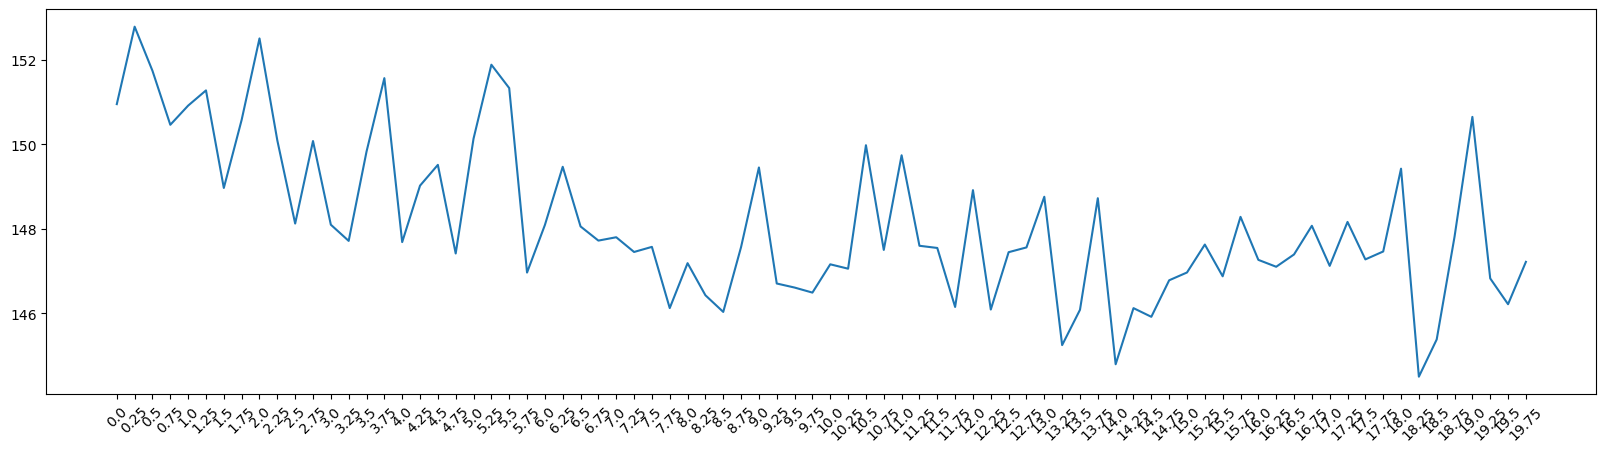

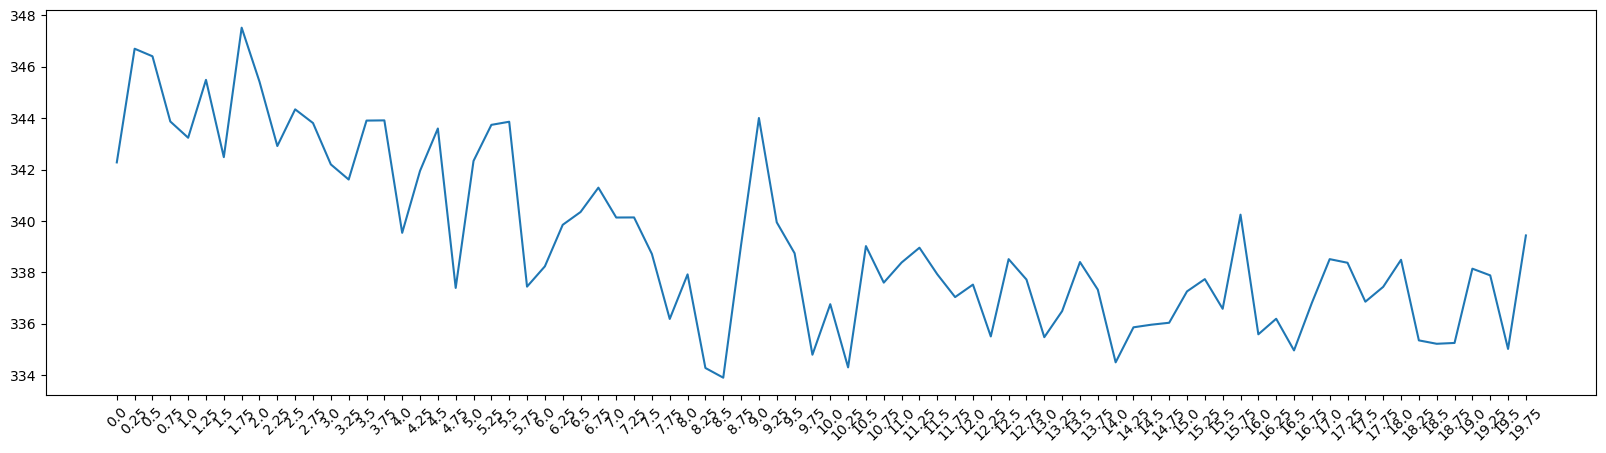

In [ ]:

for key, values in m1_CV.param_grid.items():
    pass

plt.figure(figsize=(20, 5))


sns.lineplot(y=m1_CV.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);


plt.figure(figsize=(20, 5))
sns.lineplot(y=m1_CV.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);


In [ ]:
#m1.steps[-3][1].get_feature_names_out()


<Axes: xlabel='feature'>

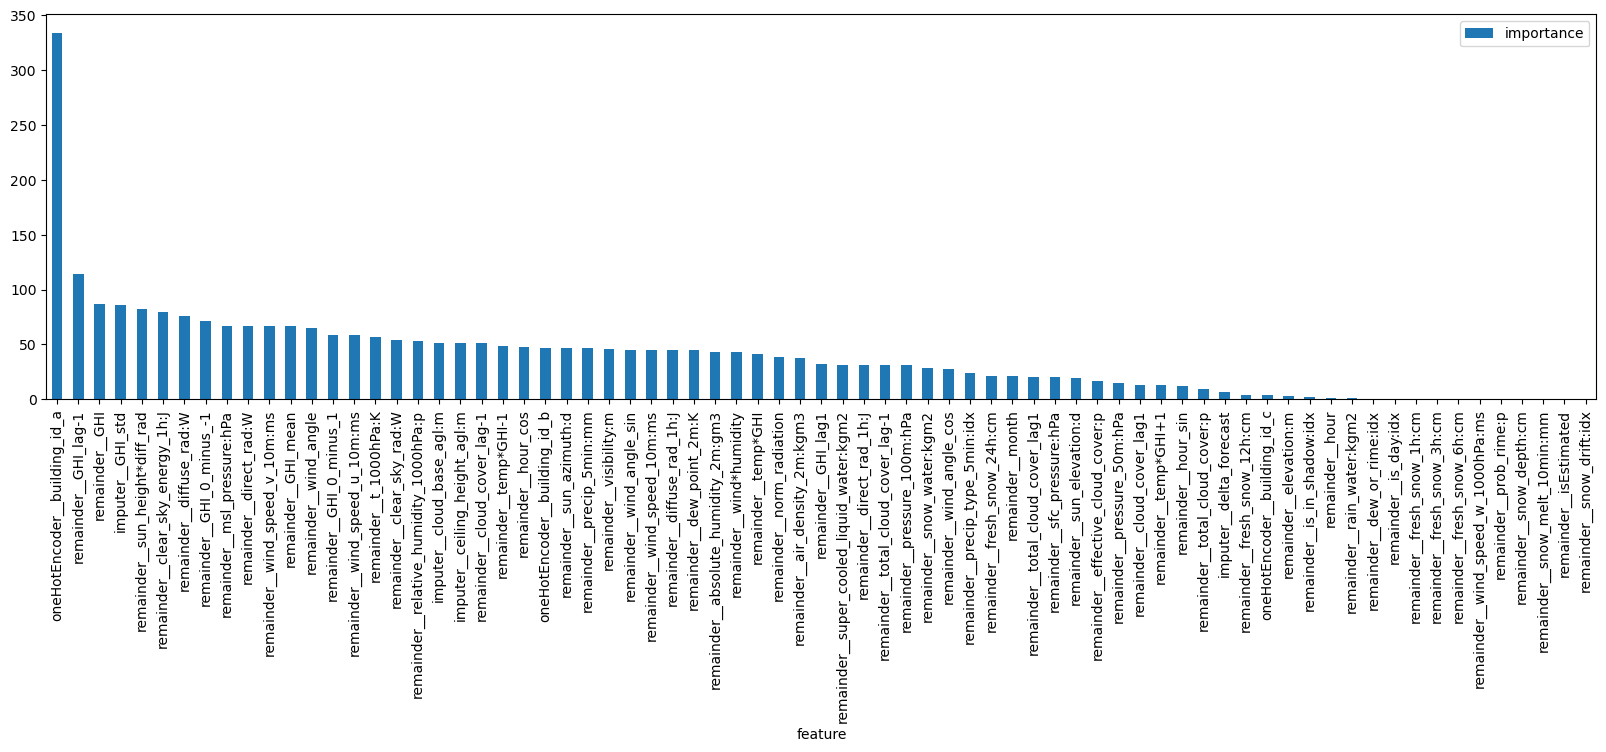

In [ ]:
f_names = m1.steps[-3][1].get_feature_names_out()
f_importances = m1.steps[-1][1].feature_importances_

f_importances_df = pd.DataFrame({'feature': f_names, 'importance': f_importances})

f_importances_df = f_importances_df.sort_values(by='importance', ascending=False)

f_importances_df.plot.bar(x='feature', y='importance', figsize=(20, 5))


In [ ]:
if type(m1_CV) == BayesSearchCV:
    _ = plot_objective(m1_CV.optimizer_results_[0])
    plt.show()

# Test model on test data

In [ ]:
# predict on estimated data
m1.fit(X_train[~test_idx].reset_index(drop=True), y_train[~test_idx].reset_index(drop=True))
m1_pred = pd.Series(m1.predict(X_test))
#m1_pred = pd.Series(full_scaler.inverse_transform(m1_pred.values.reshape(-1, 1)).flatten())
#m1_pred = y_scaler.inverse_transform(m1_pred, X_e['building_id'])
# m1_pred = y_scaler_clear_sky.inverse_transform(m1_pred, X_test['clear_sky_rad:W'])
m1_pred = y_scaler_clear_sky_y.inverse_transform(m1_pred, X_test['clear_sky_rad:W'])
m1_pred = y_scaler_MaxAbs_y.inverse_transform(m1_pred, X_test['building_id'])
Xy_test['m1_pred'] = m1_pred

# calculate abs diff
Xy_test['abs_diff'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred'])
Xy_test['diff'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred'])

# calculate mae
mae = Xy_test['abs_diff'].mean()
print('MAE:', mae)


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12366
[LightGBM] [Info] Number of data points in the train set: 22089, number of used features: 70
[LightGBM] [Info] Start training from score 603.835112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

NameError: name 'y_scaler_clear_sky_y' is not defined

<Axes: >

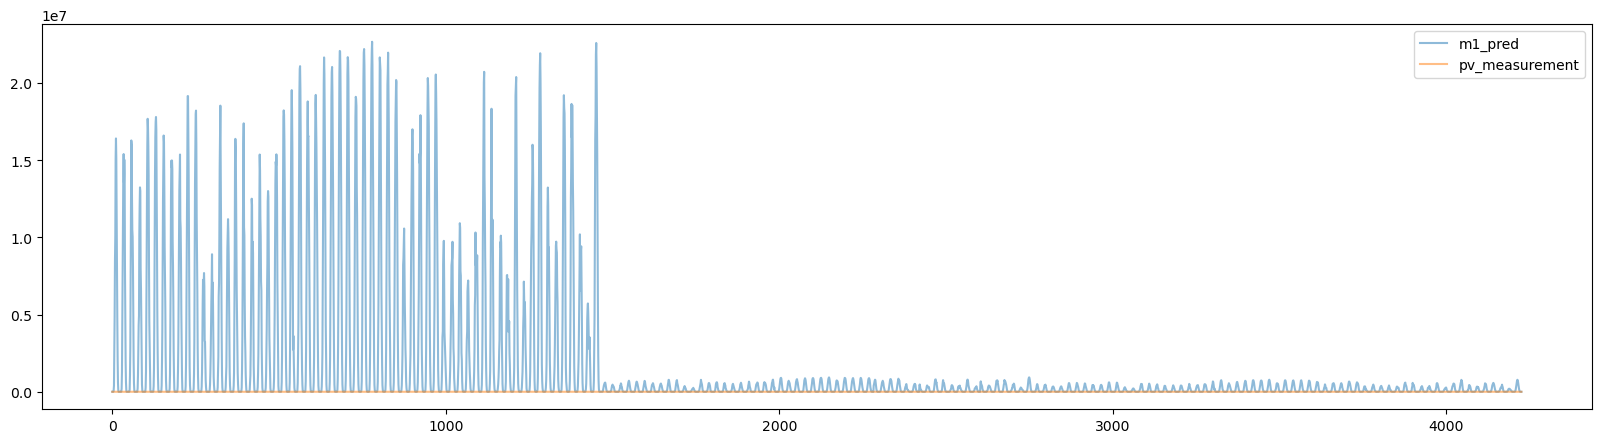

In [ ]:
Xy_test[['m1_pred','pv_measurement']].plot(figsize=(20,5), alpha=0.5)

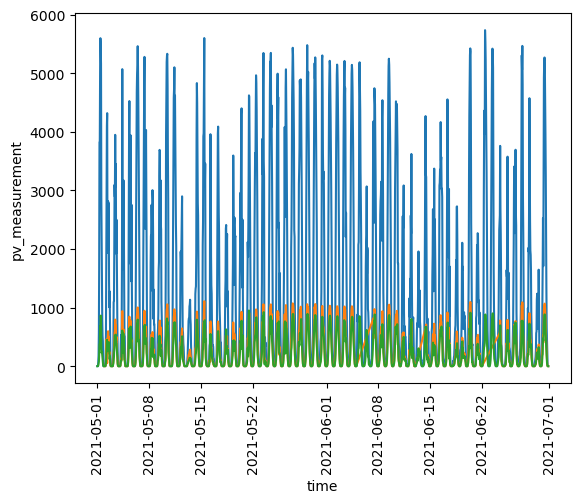

In [ ]:
sns.lineplot(data=Xy_test, x='time', y='pv_measurement', hue='building_id', legend=False)
plt.xticks(rotation=90);


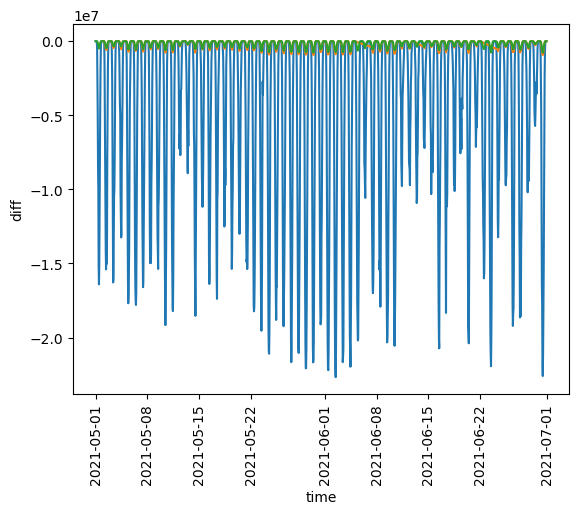

In [ ]:
sns.lineplot(data=Xy_test, x='time', y='diff', hue='building_id', legend=False)
plt.xticks(rotation=90);


In [ ]:
# Creating the submission file
m1.fit(X, y)

# prepare dataframes
y_test_pred = pd.Series(m1.predict(X_submission))
# y_test_pred = pd.Series(full_scaler.inverse_transform(
#     y_test_pred.values.reshape(-1, 1)).flatten())
#y_test_pred = y_scaler.inverse_transform(y_test_pred, X_t['building_id']).copy()
y_test_pred = y_scaler_clear_sky_y.inverse_transform(y_test_pred, X_submission['GHI']).copy()
y_test_pred = y_scaler_MaxAbs_y.inverse_transform(y_test_pred, X_submission['building_id']).copy()

# remove negative predictions
y_test_pred.iloc[y_test_pred < 0] = 0

# rename columns etc.
y_test_pred = y_test_pred.reset_index().rename(
    columns={'pv_measurement': 'prediction', 'index': 'id'})

# save submission file
y_test_pred.to_csv(
    'feature_extraction2_scaled_tuned.csv', index=False, header=True)


#